<div style="position: relative;">
<img src="https://user-images.githubusercontent.com/7065401/98728503-5ab82f80-2378-11eb-9c79-adeb308fc647.png"></img>

<h1 style="color: white; position: absolute; top:27%; left:10%;">
     Secure RESTful APIs using Python
</h1>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:56%; left:10%;">
    David Mertz, Ph.D.
</h3>

<h3 style="color: #ef7d22; font-weight: normal; position: absolute; top:63%; left:10%;">
    Data Scientist
</h3>
</div>

# Services

Suppose that you have written a few functions, and you would like to expose them for other people in your work team to use.  The examples here will process images in a few ways, but any other domain or task could pose a similar design issue.  It is certainly *possible* to bundle your functions into a module or library, and distribute it.  However, another option is simply to **expose** the capabilities as micro-services.

Let's load again one of the images we saw in the last lesson.

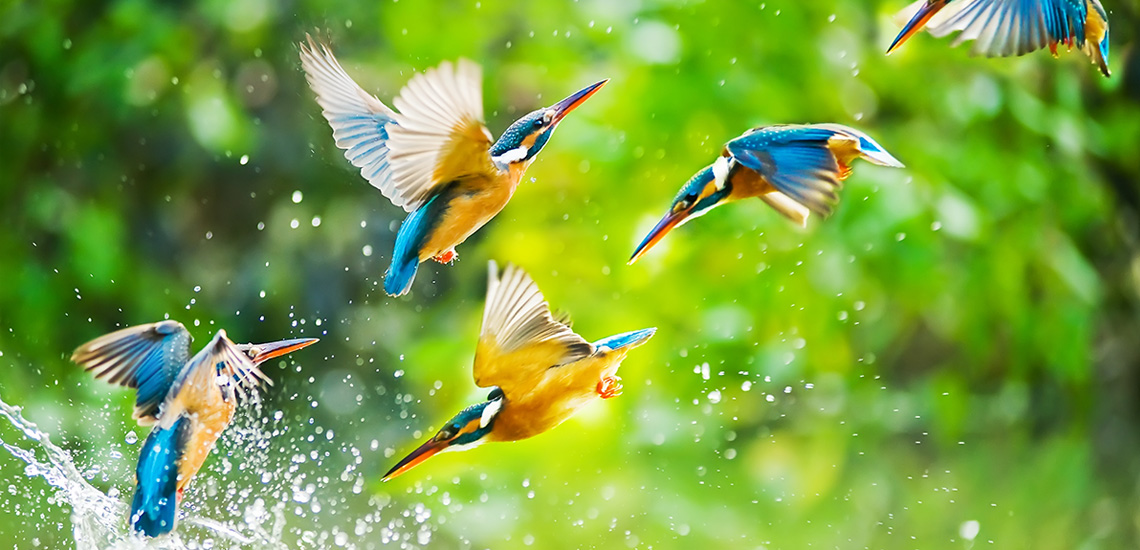

In [1]:
import numpy as np
from PIL import Image
img = Image.open('1.jpg')
img

## Functions

A few functions can be useful in analyzing or manipulating images.  For example, perhaps we would like to identify what colors regions are most prominent in a photograph.

In [2]:
from collections import Counter
from sklearn.cluster import KMeans

def prominent_colors(img, k=6):
    "Identify `k` centroids and pixel counts in colorspace of an image"
    pixels = np.asarray(img).reshape(-1, 3)
    model = KMeans(n_clusters=k)
    model.fit_predict(pixels)
    freqs = Counter(model.labels_)
    colors = np.rint(model.cluster_centers_).astype(np.uint8)
    return colors, freqs

It takes a non-trivial time for this to run on a large image.  If we were processing thousands of images, this could be significant.

In [3]:
%%time
colors, freqs = prominent_colors(img)
colors, freqs.most_common()

CPU times: user 1min 7s, sys: 14.2 s, total: 1min 21s
Wall time: 12 s


(array([[168, 199,  17],
        [102, 160,  36],
        [216, 223, 202],
        [ 35, 132, 171],
        [156, 191, 104],
        [ 58,  91,  34]], dtype=uint8),
 [(1, 173132), (5, 154997), (4, 112499), (0, 104195), (2, 64888), (3, 17289)])

---

Perhaps we would like to see these colors as HTML hex color codes.

In [4]:
def rgb2hex(rgbs):
    "Convert a NumPy array of RBB colors into their HTML hexcodes"
    assert rgbs.shape[1] == 3
    hexcodes = []
    for rgb in rgbs:
        r, g, b = rgb
        hexcodes.append(f"#{r:02x}{g:02x}{b:02x}")
    return hexcodes

In [5]:
rgb2hex(colors)

['#a8c711', '#66a024', '#d8dfca', '#2384ab', '#9cbf68', '#3a5b22']

---

Perhaps we would like to create an image showing a pie chart of prominent colors.

In [6]:
from matplotlib import pyplot as plt
from tempfile import NamedTemporaryFile

def plot_centroids(colors, counts):
    with NamedTemporaryFile() as imgfile:
        plt.pie(counts, labels=colors, colors=colors)
        plt.axis('equal')
        plt.savefig(imgfile)
        return Image.open(imgfile.name)    

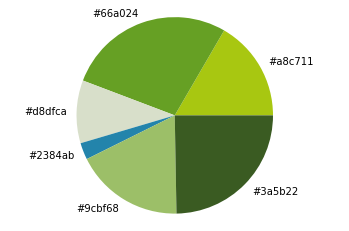

In [7]:
counts = [c[1] for c in sorted(freqs.items())]
hexcolors = rgb2hex(colors)
pie = plot_centroids(hexcolors, counts)

## Converting to micro-services

Each of these functions above can easily, and sensibly, be converted into web services.  As in the last lesson, this lesson contains a small Flask server that you can launch with:

```bash
FLASK_APP=app.py flask run
```

The heart of this script begins with:

```python
from flask import Flask, request, send_file, jsonify, abort
app = Flask(__name__)
```

A variety of imports shown earlier and the bodies of the functions already shown are also contained in the `app.py` file.  We can configure the URL details here for calling with `requests`.

In [8]:
from json import loads, dumps
import requests
host, port = 'localhost', 5000

Let's start with the `prominent_colors()`.  In this case, we modify nothing whatsoever about the prior function, merely put a little bit of wrapper to provide it as a micro-service:

```python
@app.route('/prominent-colors', methods=['POST'])
def cluster():
    img = Image.open(request.files['image'])
    k = int(request.form.get('k', 6))
    colors, freqs = prominent_colors(img, k)
    # Fixup: labels are NumPy ints rather than Python ints
    freqs = {int(k):v for k, v in freqs.items()}
    return jsonify([colors.tolist(), freqs])
```

A few things can be noted here.  The decorator `@app.route` gives what URL path the function below will respond to.  However, the actual function can be called anything at all.  Often the same name as the final portion of the path is used, but as here, it can be something different.

In the code, we take an uploaded file and read it into the variable `img` and a form field into `k`.  These are separately given in the `requests` arguments `files` and `data` since the latter needs large binary data.  Beyond that, we simply call the function `prominent_colors()` with the parameters provided, and return a JSON version of the response.  A slight fixup is needed for `freqs` because the labels are actually `numpy.int32` values rather than Python ints that we can convert to JSON directly.

Let's make a "call" to the service.

In [9]:
%%time
r = requests.post(f'http://{host}:{port}/prominent-colors', 
                  files={'image': open('1.jpg', 'rb')},
                  data={'k': 6})
colors, freqs = loads(r.text)
colors

CPU times: user 14.7 ms, sys: 3.73 ms, total: 18.4 ms
Wall time: 14.9 s


[[35, 132, 171],
 [156, 191, 104],
 [102, 160, 36],
 [216, 223, 202],
 [58, 91, 34],
 [169, 199, 17]]

No extra time was needed to connect on the local machine; in fact, it seems to run a few milliseconds faster on my system, probably because the service is already running in a separate thread.

For the next function, we create a very slight modification as a microservice.  We cannot directly send a NumPy array, but would require serialization, either using JSON, Python pickles, or some other approach.  A list-of-lists—which is what we actually got back from the prior request, is easier.

```python
@app.route('/rgb2hex', methods=['POST'])
def rgb2hex():
    "Convert a list-of-lists of RBB colors into their HTML hexcodes"
    rgbs = loads(request.form.get('rgbs', '[]'))
    hexcodes = []
    for rgb in rgbs:
        r, g, b = rgb
        hexcodes.append(f"#{r:02x}{g:02x}{b:02x}")
    return jsonify(hexcodes)
```

Not much to this.  We do not check for array dimension, and we make sure to `jsonify()` the return value, and get the arguments from the form rather than as formal arguments.  The underlying logic is the same.

In [10]:
r = requests.post(f'http://{host}:{port}/rgb2hex', 
                  data={'rgbs': dumps(colors)})
loads(r.text)

['#2384ab', '#9cbf68', '#66a024', '#d8dfca', '#3a5b22', '#a9c711']

The final micro-service we create is for rendering the pie chart of the various colors and their relative frequencies.  Again the underlying logic is the same, but we change a few minor details of parsing parameters.

```python
@app.route('/centroids', methods=['POST'])
def centroids():
    try:
        with NamedTemporaryFile() as imgfile:
            colors = loads(request.form['colors'])
            counts = loads(request.form['counts'])
            plt.pie(counts, labels=colors, colors=colors)
            plt.axis('equal')
            plt.savefig(imgfile, dpi=75)
            imgfile.flush()
            return send_file(imgfile.name, mimetype='image/png')
    except:
        abort(503)
```

Let's walk through using all of the micro-services with some slightly different options.

In [11]:
# Image 3, central 4  colors
r1 = requests.post(f'http://{host}:{port}/prominent-colors', 
                  files={'image': open('3.jpg', 'rb')},
                  data={'k': 4})
colors, freqs = loads(r1.text)

In [12]:
# Get the hex color codes
r2 = requests.post(f'http://{host}:{port}/rgb2hex', 
                   data={'rgbs': dumps(colors)})
# Still a JSON string here
hexcolors = r2.text

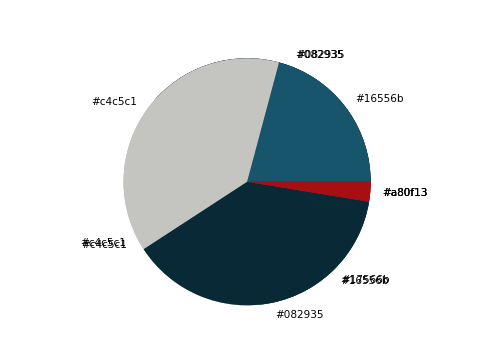

In [13]:
# Calculate the plot and return it as image
import io
counts = dumps([c[1] for c in sorted(freqs.items())])
r3 = requests.post(f'http://{host}:{port}/centroids', 
                   data={'colors': hexcolors, 'counts': counts})

Image.open(io.BytesIO(r3.content))

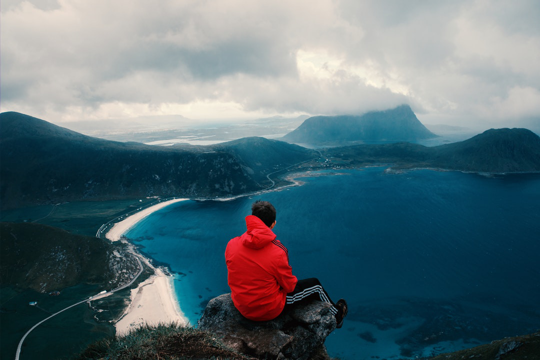

In [14]:
Image.open('3.jpg').resize((540, 360))